# **Network Analysis on Netflix Original Content**
---

# **1 | Motivation**
*In a time where streaming is more relevant than ever, more and more actors move towards that sort of media. In terms of Netflix (one of the biggest streaming services online), more and more movies are getting available every week from multiple countries around the world. Therefore, it’s interesting to investigate within the movies and the tv-series of Netflix, which countries are more prominent, as well as investigating some areas within the data where the countries differentiates, such as movie and tv actors, numbers of movies and TV shows, the descriptions in terms of a word cloud and sentimental analysis.*  

*In order to do this, we collected all the Netflix Originals Movies and TV shows from Wikipedia and combined extracted extra data from each of the Netflix Original contents from IDMb using the IMDbPy package.*

*We chose this dataset to invastigate the pattern of the actors and see what kind of movies and TV shows Netflix produces and how they are received by the audience looking at the ratings fra the IMDb.*

*We want to show the en user a complete picture of what Netflix produces and how likely they are to use the same actors or how likely the actors will act for a Netflix Originals again.*

In [ ]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/My Drive/Social graphs and interactions/ProjectB/'

In [ ]:
#Import packages
import nltk, os, re, urllib.request, io, collections, math
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('word_tokenize')
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np

from fa2 import ForceAtlas2
import networkx as nx
from operator import itemgetter

import string
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import requests
import json
import glob
from urllib.parse import urljoin
from bs4 import BeautifulSoup

!pip install geopandas
import plotly.graph_objects as go
import geopandas as gpd
from plotly.offline import init_notebook_mode, iplot

from PIL import Image
from collections import OrderedDict
from collections import Counter
import operator
import itertools
import community

!pip install IMDbPy
from imdb import IMDb
ia = IMDb()

%matplotlib inline
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# **2 | Basic Stats**


## **Data**
*The data we are analyzing, has been collected from the wikipedia pages of Netflix original programming (https://en.wikipedia.org/wiki/List_of_Netflix_original_programming) and Netflix original movies, both from 2012 - 2019 (https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2012-2019)) and from 2020 - 2029 (https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2020–2029)).* 

*Some of the content have yet to be released, and so we have decided to filter that out of the dataset. Furthermore, we decided to exclude documentaries, stand-up specials (and other specials), and reality tv series from the dataset, as it did not make sense to include that part of the data for the analysis of the data. After filtering out all content with a TBA (To Be Announced) release date and unrelated content, we combined it all into one dataset.*

*Furthermore, we decided only to keep the columns Title and Premiere date, since we didn't find it usefull to have the saesons, runtime, status and langauge for the movies and TV shows. However we wanted to keep the Genres of the Netflix Originals but since the genres were too specific on the Wikipedia pages we wanted to import a more common genre list from IMDb later.* 

### **Import Netflix Original Films and Netflix Original TV Shows**

In [ ]:
# import netflix originals from 2012-2019
url_2012 = "https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2012–2019)"
response_2012 = requests.get(url_2012)

url_2020 = "https://en.wikipedia.org/wiki/List_of_Netflix_original_films_(2020–2029)"
response_2020 = requests.get(url_2020)

# get all the tables from the wiki page
netflix_movies_before_2020 = pd.read_html(response_2012.text)
netflix_movies_2020 = pd.read_html(response_2020.text)

# from observing the page of Netflix original 2020-2029, only the first table is needed
netflix_movies_2020 = netflix_movies_2020[0] 

In [ ]:
# delete all the movies which are not released yet
for i in range(len(netflix_movies_2020)):
  if netflix_movies_2020['Premiere'][i] == 'Awaiting release':
      netflix_movies_2020_filtered = netflix_movies_2020[0:i]

In [ ]:
# combining all the tables as one table
netflix_movies = pd.concat([netflix_movies_before_2020[0], netflix_movies_2020_filtered])

# reindexing the table
netflix_movies.reset_index(drop=True, inplace=True)

In [ ]:
# importing Netflix TV Shows
url_TVshow = "https://en.wikipedia.org/wiki/List_of_Netflix_original_programming"
response_TVshow = requests.get(url_TVshow)

# get all the tables from the wiki page
netflix_tv_shows = pd.read_html(response_TVshow.text)

In [ ]:
# remove awaiting release
netflix_tv_shows_filtered = [[] for _ in range(17)]

for j in range(17):
  have = 0
  for i in range(len(netflix_tv_shows[j])):
      if str(netflix_tv_shows[j]['Premiere'][i]) == 'Awaiting release':
        have = 1
        netflix_tv_shows_filtered[j] = netflix_tv_shows[j][:i]
      else:
        pass
  if have == 0:
    netflix_tv_shows_filtered[j] = netflix_tv_shows[j].copy()

# merge all the tables 
choosen_TV_Shows = pd.concat([netflix_tv_shows_filtered[i][['Title','Premiere']] for i in range(17)])

# reset index
choosen_TV_Shows.reset_index(drop=True, inplace=True)

### **Merging and cleaning the data**

In [ ]:
# getting only the needed two columns of the movies
Movies_filtered = netflix_movies[["Title", "Premiere"]]

# combining the TV shows and movies as one table
combined = pd.concat([choosen_TV_Shows, Movies_filtered])

#Just a copy
combined2 = combined

### **IMDb - Getting the casts, rating, genre and description**

*After cleaning up the data from the Wikipedia pages and only keeping the two columns, Title and Premiere dates, the IMDb package has been used to get the cast, rating, description, genre and contries of each Netflix Originals we have stiched together in the `combined` dataframe.* 

The following functions: <br>
1.   `getmovieID`: Get a title's ID number
2.   `getcast`: Get the first 10 casts of title from the ID number
3.   `getrating`: Get the rating from the ID number
4.   `getdescription`: Get the description from the ID number
5.   `getGenre`: Get the genres of from the ID number
6.   `getCountries`: Get the countries from the ID number

*To append the data extracted from the IMDb, we first made column for each of the functions and then ran through the column `Title` in the dataframe `combined` to get the needed information for each Netflix Originals. After retrieving each informtion they got in their respective list. If the casts, rating, description, genre or contries couldn't be found we just added a `NaN` for that Title.* 

*After the for-loop ended we connected all the respective list to their column which was made. As the final preprocessing step, we added a new two new columns `Year` and `Type`. `Year` contained the premiere year of the Netflix Original which was extracted from the `Premiere` column data. The `Type` column was made to identify if a title was a Netflix Original Movie or Netflix Original TV show. If a title was a Netflix Original Movie it was assigned the binary number `0` else `1`.*

In [ ]:
# Getting the movie id
def getmovieID(movie_name):
    movie = ia.search_movie(movie_name)[0]
    get_movie = ia.get_movie(movie.movieID)
    return get_movie

# Getting the top 10 actors
def getcast(movie_name):
    movie = getmovieID(movie_name)
    casts_objects = movie.get('cast')
    casts = []
    for person in casts_objects[:10]:
        casts.append(person.get('name'))
    return casts

# Getting the rating
def getrating(movie_name):
    movie = getmovieID(movie_name)
    rating_objects = movie.data['rating'] 
    return rating_objects

# Getting the movie description
# https://www.imdb.com/title/tt2990140/plotsummary -> getting the first Synopsis
def getdescription(movie_name):
    movie = getmovieID(movie_name)
    description = movie.get('plot outline')
    return description

# Getting the genres of each movie
def getGenre(movie_name):
    movie = getmovieID(movie_name)
    genre = movie.get('genres')
    return genre

def getCountries(movie_name):
    movie = getmovieID(movie_name)
    countries = movie.get('countries')
    return countries

In [ ]:
combined['Cast'] = ''
combined['Description'] = ''
combined['Rating'] = ''
combined['Genre'] = ''
combined['Countries'] = ''

# getting top 10 casts, rating, genre and description of each movie 
listCast = []
listDescription = []
listRating = []
listGenre = []
listCountries = []

for i in combined['Title']:
  try:
    listCast.append(getcast(i))
    listDescription.append(getdescription(i))
    listRating.append(getrating(i))
    listGenre.append(getGenre(i))
    listCountries.append(getCountries(i))
  except:
    listCast.append(np.nan)
    listDescription.append(np.nan)
    listRating.append(np.nan)
    listGenre.append(np.nan)
    listCountries.append(np.nan)

In [ ]:
# reindexing them
combined.reset_index(drop=True, inplace=True)

# adding the casts, rating and movie description for each movie and TV show
combined['Cast'] = listCast
combined['Description'] = listDescription
combined['Rating'] = listRating
combined['Genre'] = listGenre
combined['Countries'] = listCountries

In [ ]:
# adding if it is a movie or TC show
combined['Type'] = ''
#TV_Shows_filtered : 1, Movies_filtered : 0 
listType = []

for i in combined['Title']:
  if i in list(Movies_filtered['Title']):
    listType.append(0)
  else:
    listType.append(1)

combined['Type'] = listType

# Adding a column with the premiere year extracted from the Premiere column data
combined['Year'] = pd.DatetimeIndex(combined['Premiere']).year

*After cleaning and preprocessing the dataframe, this how the dataframe, `combined`, looks.* 

In [ ]:
# the dataframe
combined

,Title,Premiere,Cast,Description,Rating,Genre,Countries,Type,Year
0,Stranger Things,"July 15, 2016","[Winona Ryder, David Harbour, Finn Wolfhard, M...","In a small town where everyone knows everyone,...",8.8,"[Drama, Fantasy, Horror, Mystery, Sci-Fi, Thri...",United States,1,2016
1,The Crown,"November 4, 2016","[Claire Foy, Olivia Colman, Imelda Staunton, M...",This show focuses on Queen Elizabeth II as a y...,8.7,"[Biography, Drama, History]","United Kingdom, United States",1,2016
2,Ozark,"July 21, 2017","[Jason Bateman, Laura Linney, Sofia Hublitz, S...","The Byrdes and their teenage kids, Charlotte a...",8.4,"[Crime, Drama, Thriller]",United States,1,2017
3,Lost in Space,"April 13, 2018","[Molly Parker, Toby Stephens, Maxwell Jenkins,...","Set 30 years in the future, colonization in sp...",7.3,"[Adventure, Drama, Family, Mystery, Sci-Fi]",United States,1,2018
4,Chilling Adventures of Sabrina,"October 26, 2018","[Kiernan Shipka, Ross Lynch, Lucy Davis, Chanc...",Reimagines the origin and adventures of Sabrin...,7.6,"[Drama, Fantasy, Horror, Mystery, Thriller]",United States,1,2018
...,...,...,...,...,...,...,...,...,...
492,Notes for My Son,"November 24, 2020","[Valeria Bertuccelli, Esteban Lamothe, Julian ...",None,6.4,[Drama],Argentina,0,2020
493,The Christmas Chronicles: Part Two,"November 25, 2020","[Kurt Russell, Goldie Hawn, Darby Camp, Julian...",None,6.2,"[Adventure, Comedy, Family, Fantasy]",Canada,0,2020
494,The Beast,"November 27, 2020","[Fabrizio Gifuni, Lino Musella, Monica Piseddu...","Leonida Riva is a gloomy, solitary war veteran...",5.2,"[Action, Crime, Drama, Thriller]",Italy,0,2020
495,The Call,"November 27, 2020","[Oh Jeong-Se, Jong-seo Jun, Sung-ryung Kim, Do...",None,7.2,"[Horror, Mystery, Thriller]",South Korea,0,2020


*As it can be observed above, the dataset consists of **497 rows**, where each of the rows represent a Netflix Originals titel. The attributes we have for the titles are: **Title**, **Premiere**, **Cast**, **Description**, **Rating**, **Genre**, **Countries**, **Type** & **Year**.*

In [ ]:
# The dataframe was saved as a pickle file, so the whole code doesn't have to be ran again and again if something happened.
# saving the table as pickle file
# combined.to_pickle(path + "combined.pkl")

# Reading the pickle file
combined = pd.read_pickle(path + "combined.pkl")

### **Premiere Dates & Release Countries**
*First, we wanted to see how Netflix have released their originals over time. To do so, a histogram has been made to show the number of movies and tv shows Netflix has produced. Thereafter a new dataset has been imported from* *https://fairlyvalued.com/company/NFLX*, *to compare if it actually could pay off to produce movies and TV shows for Netflix. We do assume, that they make a lot of money of their Originals since they have made a lots of content the past years. Thereafter a comparison has been made to see if their revenue has increased as they produce more content.* 

*Later a worldmap is made to show where Netflix has produced more movies and tv shows. For the ones who are just interested to see a histogram, it is also provided where the top 20 countries are plotted as x-axis.*

#### **Based by release year**

In [ ]:
# Netflix Originals release dates
releaseYears = pd.DataFrame(combined.groupby('Year').Title.nunique())

<Figure size 432x288 with 0 Axes>

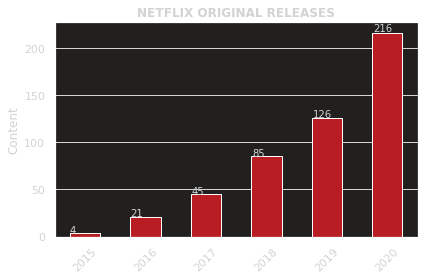

In [ ]:
fig = plt.figure(facecolor = "#221f1f")

ax = releaseYears.plot.bar(title = "Netflix original content yearly releases", rot=45,
                           color = '#b81d24')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),
                color = 'lightgrey')

ax.patch.set_facecolor("#221f1f")
plt.ylabel("Content")
plt.xlabel("")
plt.grid(color = "lightgrey")
ax.xaxis.grid(False)
ax.tick_params(colors = "lightgrey")
ax.yaxis.label.set_color('lightgrey')
ax.xaxis.label.set_color('lightgrey')
ax.set_title("NETFLIX ORIGINAL RELEASES", color = "lightgrey", fontweight = 'bold')
plt.legend().remove()
plt.tight_layout()
#plt.savefig(path + 'Netflix_releases.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

In [ ]:
release_TV = pd.DataFrame(combined.groupby(['Type','Year']).size().reset_index().groupby('Year')[[0]].min())
release_movies = pd.DataFrame(combined.groupby(['Type','Year']).size().reset_index().groupby('Year')[[0]].max())

df_split = pd.merge(release_TV, release_movies, on='Year')
df_split = df_split.reset_index()
df_split.columns = ['Year','Movie titles', 'Show titles']

<Figure size 432x288 with 0 Axes>

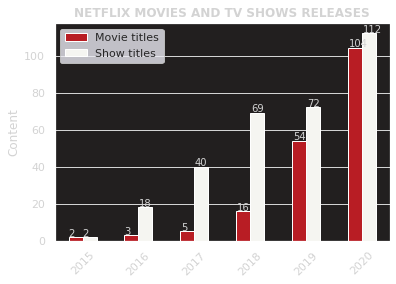

In [ ]:
fig = plt.figure(facecolor = "#221f1f")

ax = df_split.plot.bar(x='Year', color = ['#b81d24', '#f5f5f1'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),
                color = 'lightgrey')
    
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')
ax.set_facecolor('#221f1f')
plt.grid(color = "lightgrey")
ax.xaxis.grid(False)
plt.xlabel("")
plt.ylabel("Content")
ax.set_title("NETFLIX MOVIES AND TV SHOWS RELEASES", color = "lightgrey", fontweight = 'bold')
ax.tick_params(colors = "lightgrey")
ax.yaxis.label.set_color('lightgrey')
ax.xaxis.label.set_color('lightgrey')
#plt.savefig(path + 'Netflix_releases_split.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

<Figure size 432x288 with 0 Axes>

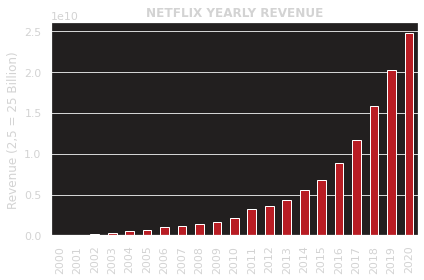

In [ ]:
# getting netflix revenue
Netflix_revenue = pd.read_csv(path + 'nflx.csv')  
Netflix_revenue['year'] = pd.DatetimeIndex(Netflix_revenue['reportperiod']).year

# We don't have the last quarterly revenue for Netflix in 2020. Therefore, we assume that in the last quarter of 2020, the revenue is equal or bigger than the previous quarter of 2020.
# We assume this by looking at the quarterly revenue of 2019.

new_date = (len(Netflix_revenue))
new_data = pd.DataFrame(Netflix_revenue[:1].values, index=[new_date], columns=Netflix_revenue.columns)
Netflix_revenue = Netflix_revenue.append(new_data)


#append row to the dataframe
Netflix_revenue = Netflix_revenue.append(new_row, ignore_index=True)
revenue = pd.DataFrame(Netflix_revenue.groupby('year').revenue.sum())

fig = plt.figure(facecolor = "#221f1f")

ax = revenue.plot.bar(rot=90, color = '#b81d24')

plt.title(str.upper("Netflix yearly revenue"), color = "lightgrey", fontweight = 'bold')
plt.ylabel("Revenue (2,5 = 25 Billion)")

ax.patch.set_facecolor("#221f1f")
ax.set_facecolor('#221f1f')
plt.xlabel("")
plt.grid(color = "lightgrey")
ax.xaxis.grid(False)

ax.tick_params(colors = "lightgrey")
ax.yaxis.label.set_color('lightgrey')
ax.xaxis.label.set_color('lightgrey')
plt.legend().remove()
plt.tight_layout()
#plt.savefig(path + 'Netflix_revenue.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

<Figure size 432x288 with 0 Axes>

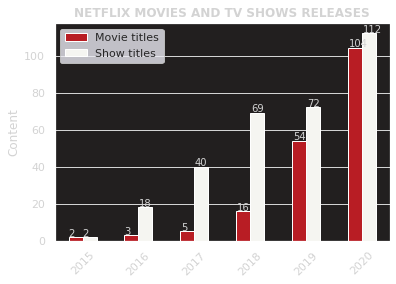

In [ ]:
fig = plt.figure(facecolor = "#221f1f")

ax = df_split.plot.bar(x='Year', color = ['#b81d24', '#f5f5f1'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),
                color = 'lightgrey')
    
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')
ax.set_facecolor('#221f1f')
plt.grid(color = "lightgrey")
ax.xaxis.grid(False)
plt.xlabel("")
plt.ylabel("Content")
ax.set_title("NETFLIX MOVIES AND TV SHOWS RELEASES", color = "lightgrey", fontweight = 'bold')
ax.tick_params(colors = "lightgrey")
ax.yaxis.label.set_color('lightgrey')
ax.xaxis.label.set_color('lightgrey')
plt.savefig(path + 'Netflix_releases_split.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

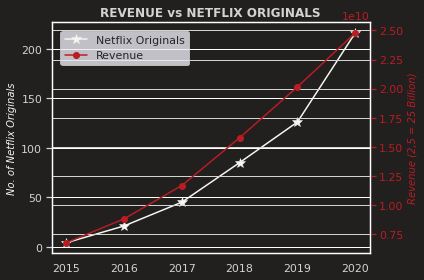

In [ ]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(facecolor = "#221f1f")

# make a plot
ax.plot(releaseYears, color="#f5f5f1", marker="*",markersize=10, markeredgewidth=.5, markeredgecolor='#f5f5f1',label='Netflix Originals')
# set x-axis label
ax.set_xlabel("")
# set y-axis label
ax.set_ylabel("No. of Netflix Originals",color="#f5f5f1",fontsize=10,style='italic')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(revenue[len(revenue)-len(releaseYears):],color='#b81d24',marker="o",label='Revenue')
ax2.set_ylabel("Revenue (2,5 = 25 Billion)",color='#b81d24',fontsize=10,style='italic')

fig.legend(loc='upper right', bbox_to_anchor=(0.45, 0.885))
ax.set_facecolor('#221f1f')
ax2.set_facecolor('#221f1f')
plt.grid(color = "lightgrey")
ax.xaxis.grid(False)
ax.set_title("REVENUE vs NETFLIX ORIGINALS", color = "lightgrey", fontweight = 'bold')
ax.tick_params(colors = "lightgrey")
ax.xaxis.label.set_color('lightgrey')
ax2.tick_params(colors = "#b81d24")
plt.tight_layout()
plt.savefig(path + 'Netflix_releasesANDrevenue.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

*As it was assumed, it can clearly be seen how the Netflix revenue is exponentially increasing as they produce more content.*

#### **Based by country**
*In order to figure out the difference in Netflix original content creation based on the different countries of the globe, we looked into creating a geoplot. The following code is a modified version of a piece of code found on Kaggle [1]. We modified it in order to get some more fitting colors, as well as getting the remaining countries to show up in the plot even though they haven't created any Netflix original content.*

In [ ]:
# Creating a dictionary with the key being a particular country and the value being the country code
country_codes = {'afghanistan': 'AFG', 'albania': 'ALB', 'algeria': 'DZA', 'american samoa': 'ASM', 'andorra': 'AND', 'angola': 'AGO',
 'anguilla': 'AIA', 'antigua and barbuda': 'ATG', 'argentina': 'ARG', 'armenia': 'ARM', 'aruba': 'ABW', 'australia': 'AUS', 'austria': 'AUT',
 'azerbaijan': 'AZE', 'bahamas': 'BHM', 'bahrain': 'BHR', 'bangladesh': 'BGD', 'barbados': 'BRB', 'belarus': 'BLR', 'belgium': 'BEL',
 'belize': 'BLZ', 'benin': 'BEN', 'bermuda': 'BMU', 'bhutan': 'BTN', 'bolivia': 'BOL', 'bosnia and herzegovina': 'BIH', 'botswana': 'BWA',
 'brazil': 'BRA', 'british virgin islands': 'VGB', 'brunei': 'BRN', 'bulgaria': 'BGR', 'burkina faso': 'BFA', 'burma': 'MMR', 'burundi': 'BDI',
 'cabo verde': 'CPV', 'cambodia': 'KHM', 'cameroon': 'CMR', 'canada': 'CAN', 'cayman islands': 'CYM', 'central african republic': 'CAF',
 'chad': 'TCD', 'chile': 'CHL', 'china': 'CHN', 'colombia': 'COL', 'comoros': 'COM', 'congo democratic': 'COD', 'Congo republic': 'COG',
 'cook islands': 'COK', 'costa rica': 'CRI', "cote d'ivoire": 'CIV', 'croatia': 'HRV', 'cuba': 'CUB', 'curacao': 'CUW', 'cyprus': 'CYP',
 'czech republic': 'CZE', 'denmark': 'DNK', 'djibouti': 'DJI', 'dominica': 'DMA', 'dominican republic': 'DOM', 'ecuador': 'ECU',
 'egypt': 'EGY', 'el salvador': 'SLV', 'equatorial guinea': 'GNQ', 'eritrea': 'ERI', 'estonia': 'EST', 'ethiopia': 'ETH', 'falkland islands': 'FLK',
 'faroe islands': 'FRO', 'fiji': 'FJI', 'finland': 'FIN', 'france': 'FRA', 'french polynesia': 'PYF', 'gabon': 'GAB', 'gambia, the': 'GMB',
 'georgia': 'GEO', 'germany': 'DEU', 'ghana': 'GHA', 'gibraltar': 'GIB', 'greece': 'GRC', 'greenland': 'GRL', 'grenada': 'GRD', 'guam': 'GUM',
 'guatemala': 'GTM', 'guernsey': 'GGY', 'guinea-bissau': 'GNB', 'guinea': 'GIN', 'guyana': 'GUY', 'haiti': 'HTI', 'honduras': 'HND', 'hong kong': 'HKG',
 'hungary': 'HUN', 'iceland': 'ISL', 'india': 'IND', 'indonesia': 'IDN', 'iran': 'IRN', 'iraq': 'IRQ', 'ireland': 'IRL', 'isle of man': 'IMN',
 'israel': 'ISR', 'italy': 'ITA', 'jamaica': 'JAM', 'japan': 'JPN', 'jersey': 'JEY', 'jordan': 'JOR', 'kazakhstan': 'KAZ', 'kenya': 'KEN',
 'kiribati': 'KIR', 'north korea': 'PRK', 'south korea': 'KOR', 'kosovo': 'KSV', 'kuwait': 'KWT', 'kyrgyzstan': 'KGZ', 'laos': 'LAO', 'latvia': 'LVA',
 'lebanon': 'LBN', 'lesotho': 'LSO', 'liberia': 'LBR', 'libya': 'LBY', 'liechtenstein': 'LIE', 'lithuania': 'LTU', 'luxembourg': 'LUX',
 'macau': 'MAC', 'macedonia': 'MKD', 'madagascar': 'MDG', 'malawi': 'MWI', 'malaysia': 'MYS', 'maldives': 'MDV', 'mali': 'MLI', 'malta': 'MLT',
 'marshall islands': 'MHL', 'mauritania': 'MRT', 'mauritius': 'MUS', 'mexico': 'MEX', 'micronesia': 'FSM', 'moldova': 'MDA', 'monaco': 'MCO',
 'mongolia': 'MNG', 'montenegro': 'MNE', 'morocco': 'MAR', 'mozambique': 'MOZ', 'namibia': 'NAM', 'nepal': 'NPL', 'netherlands': 'NLD',
 'new caledonia': 'NCL', 'new zealand': 'NZL', 'nicaragua': 'NIC', 'nigeria': 'NGA', 'niger': 'NER', 'niue': 'NIU', 'northern mariana islands': 'MNP',
 'norway': 'NOR', 'oman': 'OMN', 'pakistan': 'PAK', 'palau': 'PLW', 'panama': 'PAN', 'papua new guinea': 'PNG', 'paraguay': 'PRY', 'peru': 'PER',
 'philippines': 'PHL', 'poland': 'POL', 'portugal': 'PRT', 'puerto rico': 'PRI', 'qatar': 'QAT', 'romania': 'ROU', 'russia': 'RUS', 'rwanda': 'RWA',
 'saint kitts and nevis': 'KNA', 'saint lucia': 'LCA', 'saint martin': 'MAF', 'saint pierre and miquelon': 'SPM', 'saint vincent and the grenadines': 'VCT',
 'samoa': 'WSM', 'san marino': 'SMR', 'sao tome and principe': 'STP', 'saudi arabia': 'SAU', 'senegal': 'SEN', 'serbia': 'SRB', 'seychelles': 'SYC',
 'sierra leone': 'SLE', 'singapore': 'SGP', 'sint maarten': 'SXM', 'slovakia': 'SVK', 'slovenia': 'SVN', 'solomon islands': 'SLB', 'somalia': 'SOM',
 'south africa': 'ZAF', 'south sudan': 'SSD', 'spain': 'ESP', 'sri lanka': 'LKA', 'sudan': 'SDN', 'suriname': 'SUR', 'swaziland': 'SWZ', 'sweden': 'SWE',
 'switzerland': 'CHE', 'syria': 'SYR', 'taiwan': 'TWN', 'tajikistan': 'TJK', 'tanzania': 'TZA', 'thailand': 'THA', 'timor-leste': 'TLS', 'togo': 'TGO',
 'tonga': 'TON', 'trinidad and tobago': 'TTO', 'tunisia': 'TUN', 'turkey': 'TUR', 'turkmenistan': 'TKM', 'tuvalu': 'TUV', 'uganda': 'UGA',
 'ukraine': 'UKR', 'united arab emirates': 'ARE', 'united kingdom': 'GBR', 'united states': 'USA', 'uruguay': 'URY', 'uzbekistan': 'UZB',
 'vanuatu': 'VUT', 'venezuela': 'VEN', 'vietnam': 'VNM', 'virgin islands': 'VGB', 'west bank': 'WBG', 'yemen': 'YEM', 'zambia': 'ZMB', 'zimbabwe': 'ZWE'}

# adding countries as string
for n in range(len(combined['Title'])):
  try: 
    combined['Countries'][n] = ", ".join(combined['Countries'][n])
  except:
    pass


# Creating a colorscale with different variants of red
colorscale = ["#f7fbff","#F0DBDB","#F5D6D6","#FAD1D1","#FFCCCC","#F5A3A3","#FF9999","#F07575","#FF6666","#FF3333","#FF0000","#CC0000","#990000"]

# Defining a function that takes a dataframe as an argument and creates a geoplot from the data received from the column "Countries" in said dataframe.     
def geoplot(ddf):
    country_with_code, country = {}, {}
    shows_countries = ", ".join(ddf['Countries'].dropna()).split(", ")
    for c,v in dict(Counter(shows_countries)).items():
        code = ""
        if c.lower() in country_codes:
            code = country_codes[c.lower()]
        country_with_code[code] = v
        country[c] = v

    data = [dict(type = 'choropleth', locations = list(country_with_code.keys()),
                 z = list(country_with_code.values()), colorscale = colorscale, 
                 marker = dict(line = dict (color = 'gray', width = 0.5)), 
                 colorbar = dict(autotick = False, title = ''),)]

    layout = dict(title = 'NETFLIX ORIGINALS DISTRIBUTION', 
                  geo = dict(showframe = False, showcoastlines = True, 
                             coastlinecolor="lightgrey", 
                             projection = dict(type = 'Mercator')))

    fig = dict(data=data, layout=layout)
    iplot(fig, validate=False, filename='d3-world-map')
    return country
    
country_vals = geoplot(combined)

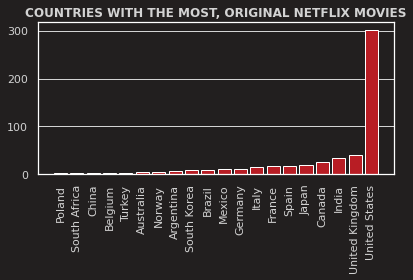

In [ ]:
fig, ax = plt.subplots(facecolor = "#221f1f")
country_vals_sliced = dict(Counter(country_vals).most_common(20))
country_vals_sort = {k: v for k, v in sorted(country_vals_sliced.items(), key=lambda x: x[1])}

labels, values = zip(*country_vals_sort.items())
plt.bar(labels, values, color = '#b81d24')

#ax.set_facecolor('#221f1f')
plt.title("COUNTRIES WITH THE MOST, ORIGINAL NETFLIX MOVIES", color = "lightgrey", fontweight = 'bold')
plt.xticks(rotation=90)
ax.tick_params(colors = "lightgrey")
ax.yaxis.label.set_color('lightgrey')
ax.xaxis.label.set_color('lightgrey')
ax.set_facecolor('#221f1f')
plt.grid(color = "lightgrey")
ax.xaxis.grid(False)
plt.tight_layout()
plt.savefig(path + 'countries_histo.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

# **3 | Tools, theory and analysis**#

*The goal of the network is to figure out the trend of the Netflix original content, as well as figuring out the distribution of content in different genres, the sentiment score of the different pieces of content and the sentiment score of the reviews of some of this content, collected from IMDb.*  

## **Network Graph**
*Firstly, we will be creating the network from the dataframe we previously created from wiki and IMDb.*

### **Graph**
*The graph is drawn by using Networkx and the node size is dictated by the number of edges a given node has.*

*NetworkX is a Python library for studying graphs and networks. With Networkx it is possible to create, manipulate, study structure, functions, etc. [2]*

In [ ]:
T# See if any no casts movies or shows
removingItems = combined[combined.Cast.isnull()].Title
print("TV shows or movies without casts:", ", ".join(pd.Series.to_list(removingItems)))

# remove movies without casts 
combined.dropna(subset=['Cast'], inplace=True)
combined.reset_index(drop=True, inplace=True)

TV shows or movies without casts: Mighty Little Bheem, Mighty Little Bheem: Festival of Colors, Word Party Songs


In [ ]:
G = nx.Graph()
casting = []

# Making as dict to make the graph 
dictOfCast = dict(zip(combined.Title,combined.Cast))
b = 0

for n in dictOfCast.keys():
  G.add_node(n)
  print("Add Node:", n)
  if combined.Type[b] == 0:
    print("First if node:", n)
    netflixType = 'TV Show'
    G.nodes[n]['netflixType'] = netflixType
  else:
    print("MOVIES node:", n)
    netflixType = 'Movie'
    G.nodes[n]['netflixType'] = netflixType
  
  try:
    casting = dictOfCast[n]
    for c in casting:
      for node, cast in dictOfCast.items() :
        if c in cast:
          G.add_edge(n,node)
          break
  except:
        print('Failed for', n,node)
  
  b = b + 1

print('Network is finished...')

In [ ]:
print(color.BOLD + "Number of edges:" + color.END, G.number_of_edges())
print(color.BOLD + "Number of nodes:" + color.END, G.number_of_nodes())

Number of edges: 932
Number of nodes: 494


In [ ]:
# The density of the graph
density_G = nx.density(G)
print(color.BOLD + "Network density:" + color.END, density_G)

Network density: 0.007653710653603896


In [ ]:
# Creates a subgraph of G of the Giant Connected Component 
Gcc_G =  G.subgraph(max(nx.connected_components(G), key=lambda x: len(x)))

In [ ]:
# Taking only the GCC
print(color.BOLD + "Number of edges:" + color.END, Gcc_G.number_of_edges())
print(color.BOLD + "Number of nodes:" + color.END, Gcc_G.number_of_nodes())

Number of edges: 671
Number of nodes: 287


In [ ]:
# The density of the subgraph GCC
density_GCC = nx.density(Gcc_G)
print(color.BOLD + "Network density:" + color.END, density_GCC)

Network density: 0.016349504154382202


*Next we are using the forceatlas2 layout when drawing our graph. ForceAtlas2 is a layout algorithm for network graph manipulation [3].*

In [ ]:
# Create the position 
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        edgeWeightInfluence=0.0,

                        # Performance
                        jitterTolerance=0.1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=1,
                        strongGravityMode=True,
                        gravity=1,
    
                        # Log
                        verbose=False)

positions = forceatlas2.forceatlas2_networkx_layout(Gcc_G, pos=None, iterations=2000)

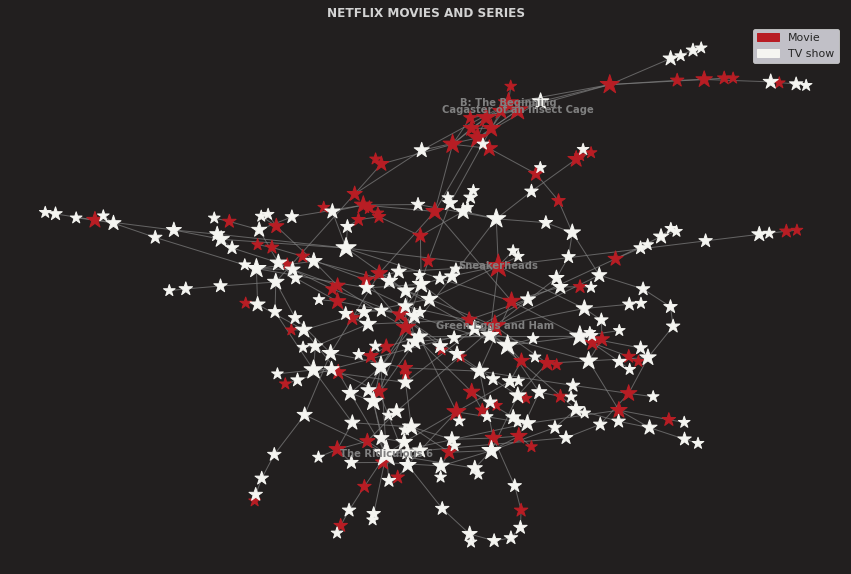

In [ ]:
#for name in G.nodes() | Coloring:
# https://colorswall.com/images/palettes/netflix-colors-palette-113-colorswall.png
# https://i.pinimg.com/originals/79/48/a6/7948a668def68f8712279df661e9dd68.png 
color_map=[]
for node, attr in Gcc_G.nodes(data=True):
    if (attr.get('netflixType') == "TV Show"):
        color_map.append("#f5f5f1")
    else:
        color_map.append("#b81d24")

        
# size of nodes according to importance
node_size=[1+value*50 for node, value in Gcc_G.degree()]
  
# draw
fig = plt.figure(figsize=(15,10), facecolor = "#221f1f")
node_label={}
for node, value in sorted(Gcc_G.degree(), key=lambda x:x[1], reverse=True)[:5]:
    node_label[node] = node


# nodes
nx.draw_networkx_nodes(Gcc_G, positions, node_size = node_size,
                       node_color=color_map, node_shape='*', 
                        alpha=1)

# edges
nx.draw_networkx_edges(Gcc_G, positions, edge_color="grey", alpha=0.7, arrows=False)

# draw biggest labels
nx.draw_networkx_labels(Gcc_G, positions, labels=node_label, font_color="grey", font_size=10, font_weight="bold")

# legend
plt.axis('off')
#fig.set_facecolor("#221f1f")
plt.title("NETFLIX MOVIES AND SERIES", fontweight='bold', color = "lightgrey")
legend = [mpatches.Patch(color='#b81d24', label='Movie')]
legend.append(mpatches.Patch(color='#f5f5f1', label='TV show'))
plt.legend(handles=legend)
#plt.savefig(path + 'MoviesAndSeries_graph.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

*It serves as a nice visualization of the network of original content. As we can observe, the nodes with the highest number of edges are visualized with their name in the graph; nodes such as, "Sneakerheads, The Ridiculous 6, etc.". We will be looking into this later on in the project.*

In [ ]:
# We create a for-loop that loops through all the edges of the GCC graph and if an edge is found that is between a node from Netflix movies and a node from Netflix TV shows, it will add 1 to the variable Movie_TV_Edges. 
# which will continue to count +1 every time an edge is found
Movies_TV_edges = 0
for (u,v) in Gcc_G.edges():
  if Gcc_G.nodes[u]["netflixType"] == "TV Show" and Gcc_G.nodes[v]["netflixType"] == "Movie" or Gcc_G.nodes[u]["netflixType"] == "Movie" and Gcc_G.nodes[v]["netflixType"] == "TV Show":
      Movies_TV_edges += 1

print(color.BOLD + "The number of edges between Netflix Movies and TV shows:" + color.END, Movies_TV_edges)

The number of edges between Netflix Movies and TV shows: 151


In [ ]:
#Sorting to get largest nodes 
degree_dict = dict(G.degree(G.nodes()))
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

# print top 10 nodes
print(color.BOLD + "Top 10 nodes by degree:" + color.END)
for d in sorted_degree[:10]:
    print(d)

Top 10 nodes by degree:
('The Ridiculous 6', 15)
('Sneakerheads', 12)
('Green Eggs and Ham', 10)
('B: The Beginning', 9)
('Cagaster of an Insect Cage', 9)
("Dragon's Dogma", 9)
('The Do-Over', 9)
('Small Crimes', 9)
('The Babysitter', 9)
('Bird Box', 9)


In [ ]:
# In which regime is the network?
# get the number p and N
p = density_G
N = G.number_of_nodes()

kcr = p*(N-1)
print(color.BOLD + "The average degree of the network is:" + color.END, round(kcr,4))

d = math.log(N)/math.log(kcr)
print(color.BOLD + "The average distance is:" + color.END, round(d,4)) 


The average degree of the network is: 3.7733
The average distance is: 4.6708


In [ ]:
print("lnN : ", np.log(N))


lnN :  6.202535517187923


*Most of the networks in real life are in the supercritical regime, hence they are expected to be broken into numerous isolated components.* 

*Since the real dataset is used, as we expected, the average degree of the network $‹k› = p(N-1) = 3.7738 > 1$.* 

*Let us now turn to the second prediction, inspecting if we have single component (i.e. if $‹k› > lnN$), or if the network is fragmented into multiple components (i.e. if $‹k› < lnN$). Since in our network $‹k› = 3.7738 < lnN = 6.2025$, the network is fragmented into multiple components.*

#### **Shortest path theory**

*Next we will be analyzing the connectivity of the different content using the plotting library <u>Matplotlib</u>.*

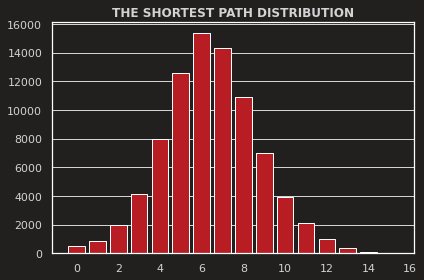

In [ ]:
# combined['Title'] list.remove(element)
shortest_path = []
temp = []

for content1 in combined['Title']:
  for content2 in combined['Title']:
    try :
      temp.append(nx.shortest_path_length(G, source=content1, target=content2))
    except :
      temp.append(np.nan)
  shortest_path.append(temp)
  temp = []

# Average shortest path length of Gcc 
nx.average_shortest_path_length(Gcc_G)

all_path = []
for content1 in shortest_path:
  for content2 in content1:
    all_path.append(content2) 

dict_shortest_path = Counter(all_path)

X = dict_shortest_path.keys()

fig, ax = plt.subplots(facecolor = "#221f1f")
ax.patch.set_facecolor("#221f1f")
plt.bar(X, list(map(float, list(dict_shortest_path.values()))), color= '#b81d24')
# plt.xticks(X, sentiment_dict_genre.keys())
plt.title(str.upper("The shortest path distribution"), color = "lightgrey", fontweight = 'bold')
plt.grid(color = "lightgrey")
ax.xaxis.grid(False)
ax.tick_params(colors = "lightgrey")
ax.yaxis.label.set_color('lightgrey')
ax.xaxis.label.set_color('lightgrey')
plt.tight_layout()
plt.savefig(path + 'ShortestPath.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

*The shortest path distribution is plotted to observe the connectivity of content. To calculate the shortest path length, nx.shortest_path_length is used in each content and it is counted in each length of path.*

*As it can be seen, the distribution follows normal distribution. The netflix original content is connected by average 6.4972 common actors edges.* 

#### **Betweenness centrality & Degree centrality**

*We continue to analyze the connectivity between the nodes. This time by looking at the betweenness centrality and degree centrality.*

*The betweenness centrality looks into the importance of the different nodes within the network. These nodes (movies and shows) are important to the network due to the amount of flowing traffic passing through these nodes to other nodes of the network.*

*The degree centrality looks into the number of edges a given node has.*

In [ ]:
# Between Centrality
between_centrality = nx.betweenness_centrality(Gcc_G)
between_centrality_sorted = sorted(between_centrality.items(), key=lambda x:x[1], reverse=True)[0:5]

print (color.BOLD + "Betweeness : The 5 most central accounts are:" + color.END)
for x in range(len(between_centrality_sorted[:5])): 
    print(between_centrality_sorted[x])

Betweeness : The 5 most central accounts are:
('Ghost in the Shell: SAC_2045', 0.1711078740671113)
('Sneakerheads', 0.15697168689054442)
('The Ridiculous 6', 0.15514594117832986)
('Jurassic World Camp Cretaceous', 0.12652352997550248)
('The Epic Tales of Captain Underpants in Space', 0.1151732339265085)


In [ ]:
# Degree Centrality
degree_centrality = nx.degree_centrality(Gcc_G)
degree_centrality_sorted = sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True)[0:5]

print (color.BOLD + "Degree : The 5 most central accounts are:" + color.END)
for x in range(len(degree_centrality_sorted[:5])): 
    print(degree_centrality_sorted[x])

Degree : The 5 most central accounts are:
('The Ridiculous 6', 0.05244755244755245)
('Sneakerheads', 0.04195804195804196)
('Green Eggs and Ham', 0.03496503496503497)
('B: The Beginning', 0.03146853146853147)
('Cagaster of an Insect Cage', 0.03146853146853147)


#### **Degree distribution**

*We will now be analyzing the degree distribution of the network.*

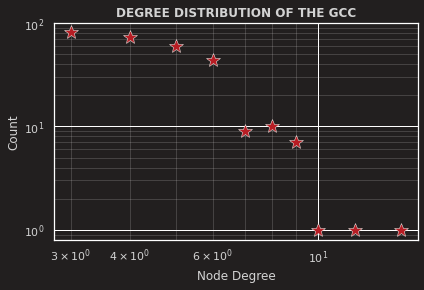

In [ ]:
# plotting the degree distribution
fig, ax = plt.subplots(facecolor = "#221f1f")
degree = np.array(list(dict(Gcc_G.degree).values()))

v = np.arange(degree.min(), degree.max()+2) 
hist, bin_edges = np.histogram(degree, bins = v - 1/2);
center = ((bin_edges[:-1] + bin_edges[1:])) / 2
plt.loglog(center, hist, 'go', marker = '*', color='#b81d24', markersize=15, markeredgewidth=.5, markeredgecolor='#f5f5f1');

#plt.legend("Degree")
plt.ylabel('Count')
plt.xlabel('Node Degree')
ax.tick_params(colors = "lightgrey")
ax.yaxis.label.set_color('lightgrey')
ax.xaxis.label.set_color('lightgrey')
ax.tick_params(axis='x', colors='lightgrey', width=5, which='both')

ax.set_facecolor('#221f1f')
plt.grid(color = "lightgrey", which='minor', alpha=0.2)
plt.tight_layout()
plt.title('DEGREE DISTRIBUTION OF THE GCC', color = "lightgrey", fontweight = 'bold')
plt.savefig(path + 'DegreeDistrubu.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

*We can observe that more than 70% of nodes have less than 7 degree in our greatest component of network. And there are 3 nodes with degree 10, 12 and 15 which are the most connected nodes, called hubs. The average of the degree of Gcc is 4.676. And almost 28% of the nodes have degree three (i.e, $p_1 = 0.2822$), while we have only one copy of the biggest node(i.e, $p_{15} = 0.00348$).*

*This means Netflix content is sharing 4.676 actors in average. And the content sharing three actors is approximately 28%, while there is one piece sharing 15 actors with the content.* 

### **Genre Distribution**

*Next, we will be looking into the different genres of the Netflix original content.*

In [ ]:
# splitting all the genres for Tvshows and Movies
tvShow_genre = []
movie_genre = []
index = 0
for i in combined['Type']:
  if i==0:
    movie_genre.append(combined['Genre'][index])
  else:
    tvShow_genre.append(combined['Genre'][index])
  index = index + 1

# dropping nan's
tvShow_genre = [x for x in tvShow_genre if str(x) != 'nan']
movie_genre = [x for x in movie_genre if str(x) != 'nan']

# making counter
tvShowGenre = Counter(itertools.chain.from_iterable(tvShow_genre))
moviesGenre = Counter(itertools.chain.from_iterable(movie_genre))


In [ ]:
# checking if the keys exist in each other in order to do the histogram afterwards
for i in tvShowGenre.keys():
  if i in moviesGenre.keys():
    pass
  else:
    moviesGenre[i] = 0

for i in moviesGenre.keys():
  if i in tvShowGenre.keys():
    pass
  else:
    tvShowGenre[i] = 0

# ordering in alphabetical after addding 
tvShowGenre = OrderedDict(sorted(tvShowGenre.items()))
moviesGenre = OrderedDict(sorted(moviesGenre.items()))

# both combined 
genre = dict(Counter(tvShowGenre)+Counter(moviesGenre))

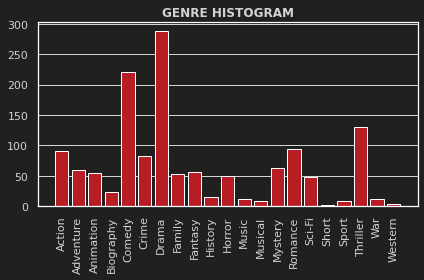

In [ ]:
fig, ax = plt.subplots(facecolor = "#221f1f")

plt.bar(list(genre.keys()), genre.values(), color = '#b81d24')
ax.tick_params(colors = "lightgrey")
ax.yaxis.label.set_color('lightgrey')
ax.xaxis.label.set_color('lightgrey')
ax.set_facecolor('#221f1f')
plt.grid(color = "lightgrey")
ax.xaxis.grid(False)
plt.xticks(rotation = 90)
plt.title(str.upper("Genre histogram"), color = "lightgrey", fontweight = 'bold')
plt.tight_layout()
plt.savefig(path + 'Genre_Hist.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

*To see how many pieces they made in each genre, we made genre histogram with 21 genres from IMDb. This includes Tv shows and Movies both. As it is mentioned above, each genre is taken from IMDb as a list. For instance, "The Christmas Chronicles" is classified as Christmas, Fantasy, Adventure, Comedy genres. Therefore, it will be counted towards all four genres.*

*The most produced genre is Drama followed by Comedy, while the least produced genre is Short followed by Western.*

*Let's see in each type of content, Tv shows and Movies.*

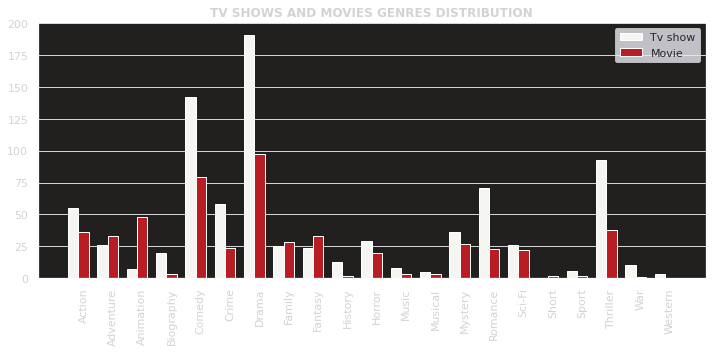

In [ ]:
# creating the bar
X = np.arange(len(tvShowGenre))
plt.figure(figsize=(10,5))
ax = plt.subplot(111)

ax.bar(X-0.35, moviesGenre.values(), width=0.35, color='#f5f5f1', align='center')
ax.bar(X, tvShowGenre.values(), width=0.35, color='#b81d24', align='center')

ax.legend(('Tv show','Movie'))
plt.xticks(X, tvShowGenre.keys())
plt.xticks(rotation = 90)
plt.title(str.upper("Tv shows and Movies genres distribution"), color = "lightgrey", fontweight = 'bold')
ax.tick_params(colors = "lightgrey")
ax.yaxis.label.set_color('lightgrey')
ax.xaxis.label.set_color('lightgrey')
ax.set_facecolor('#221f1f')
plt.grid(True, color = "lightgrey", which='both')
ax.xaxis.grid(False)
plt.tight_layout()
plt.savefig(path + 'Genre_Split_Hist.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

*The histogram is visualized to see genre distribution in Tv show and Movie. In the case of Tv show, the most produced genre is Drama followed by Comedy. Similarly, the most produced genre of Movie is Drama followed by Comedy. The least produced genre in Tv show is Musical followed by Western. Meanwhile the least produced genre in Movie is Short, which haven't made, follwed by Western. Moreover, we can observe that Netflix filmed more Tv show than Movie.* 

### **Word Clouds**

*Now we will be analyzing the content by looking at the discriptions of the different movies and shows within each genre using the library WordCloud. WordCloud is a library where it is possible to make a visual representation of text data. The WordCloud displays the most frequent words, where the importance of each word is being shown with font size or color. For quick perceiving, this format is very useful [4]. For a better WordCloud the <u>NLTK's word tokenizer</u> has also been used in order to token each word in a text and thereafter remove the stopwords using the <u>NLTK's stopwords</u>. Stopwords are English words which does not add much meaning to a sentence and can safely be ignored without sacrificing the meaning of the sentence [5]. Words such as, "it, as, he, where, etc." applies as being stopwords.*

In [ ]:
# The wordcloud colorpalette
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 5.0 / 255.0)
    s = int(100.0 * 229.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 130)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

#### **Genre**

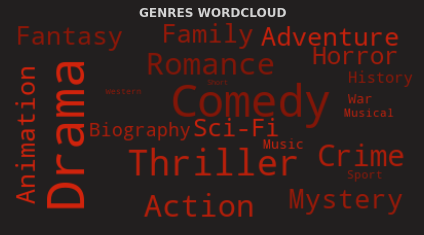

In [ ]:
# drawing the wordclouds of Genres
wordcloud_GenreNames = WordCloud(max_font_size=50, max_words=100, background_color="#221F1F", color_func=random_color_func).generate_from_frequencies(genre)

fig = plt.figure(facecolor = "#221f1f")
plt.imshow(wordcloud_GenreNames, interpolation='bilinear')
plt.title(str.upper("Genres Wordcloud"), color = "lightgrey", fontweight = 'bold')
plt.axis("off")
plt.tight_layout()
#plt.savefig(path + 'WordCloud_Genres.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 300)
plt.show()

*As an extra little treat, and as an introduction to the word clouds, we thought it could be fun to visualize the result with the different genres we have plotted above, as a word cloud instead of a bar plot. In the word cloud, we can clearly observe that the genre "Drama" is much more prominent than the other genres.* 

#### **Accordingly to TV shows and Movies**

In [ ]:
# Combining all the description accordingly to TV shows and Movies
TV_Shows_description = []
Movies_description = []

i = 0
for n in range(len(combined.Title)):
  if combined.Type[n] == 1:
#    print("Added desc:", n)
    TV_Shows_description.append(combined.Description[i])
#    print("TV", i)
  else:
#    print("MOVIES node:", n)
    Movies_description.append(combined.Description[i])
#    print("Movie", i)
  
  i += 1

# make list as one string - nans in list
TV_Shows_description = ''.join([str(i) for i in TV_Shows_description])
Movies_description = ''.join([str(i) for i in Movies_description])

In [ ]:
# Defining a variable using built in functions stopwords and punctuation in order to remove stopwords
stop  = stopwords.words('english')

# Tokenizing the texts and removing stopwords
tokensTV = [i for i in word_tokenize(TV_Shows_description.lower()) if i not in stop]
tokensMovies = [i for i in word_tokenize(Movies_description.lower()) if i not in stop]

# remove movies without casts and description
combined.dropna(subset=['Cast'], inplace=True)
combined.dropna(subset=['Description'], inplace=True)
combined.reset_index(drop=True, inplace=True)

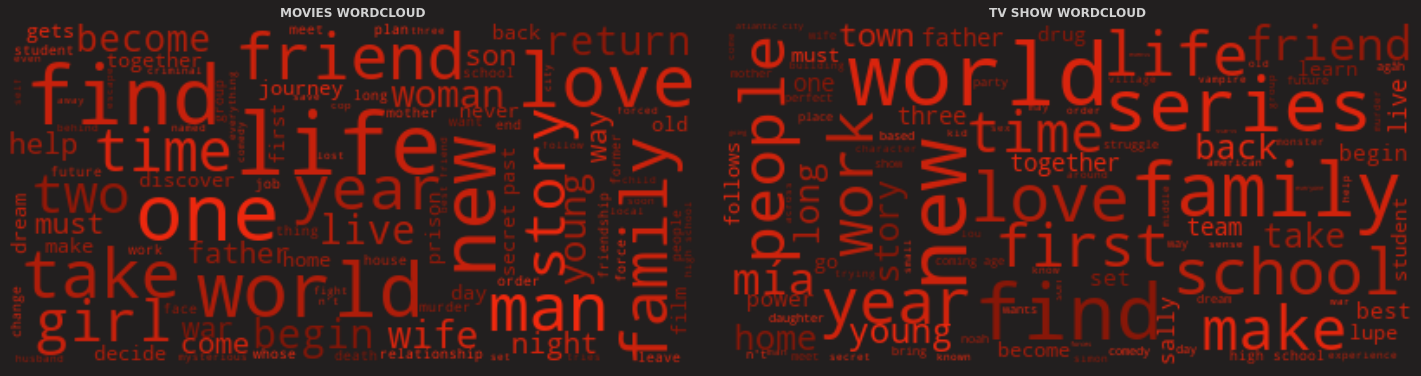

In [ ]:
# drawing the wordclouds
tokensMovie_str = ' '.join(tokensMovies)
wordcloud_Movies = WordCloud(max_font_size=50, max_words=100, background_color="#221F1F", color_func=random_color_func).generate(tokensMovie_str)

tokensTV_str = ' '.join(tokensTV)
wordcloud_TV = WordCloud(max_font_size=50, max_words=100, background_color="#221F1F", color_func=random_color_func).generate(tokensTV_str)

fig = plt.figure(figsize=(20,7), facecolor = "#221f1f")
# Movies wordcloud:
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_Movies, interpolation='bilinear')
plt.title(str.upper("Movies Wordcloud"), color = "lightgrey", fontweight = 'bold')
plt.axis("off")
print("\n")

# TV show wordcloud:
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_TV, interpolation='bilinear')
plt.title(str.upper("TV Show Wordcloud"), color = "lightgrey", fontweight = 'bold')
plt.axis("off")
plt.subplots_adjust(wspace = 6)
plt.tight_layout()
plt.savefig(path + 'WordCloud_MoviesAndTvShows.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 300)
plt.show()

*The word clouds for Movie and Tvshow are implemented. As it is observed, Drama and Comedy are the most produced genres in both Tv show and Movie. Therefore, the words "family", "life", "new", "love", "world" are overlapped which can be easily seen in the Drama and Comedy genre description.*

#### **According to the Genres**

In [ ]:
# Make dictionary {Genre:description}
GenreDescription = {}
for i in range(len(list(genre.keys()))):
  GenreDescription[list(genre.keys())[i]] = []

for n in range(len(combined['Genre'])):
  for j in combined['Genre'][n]:
    GenreDescription.setdefault(j, []).append(combined['Description'][n])

# Join all the descriptions accordingly to their Genres
documentComList = []
for key, value in GenreDescription.items():
  documentComList.append(" ".join(value))

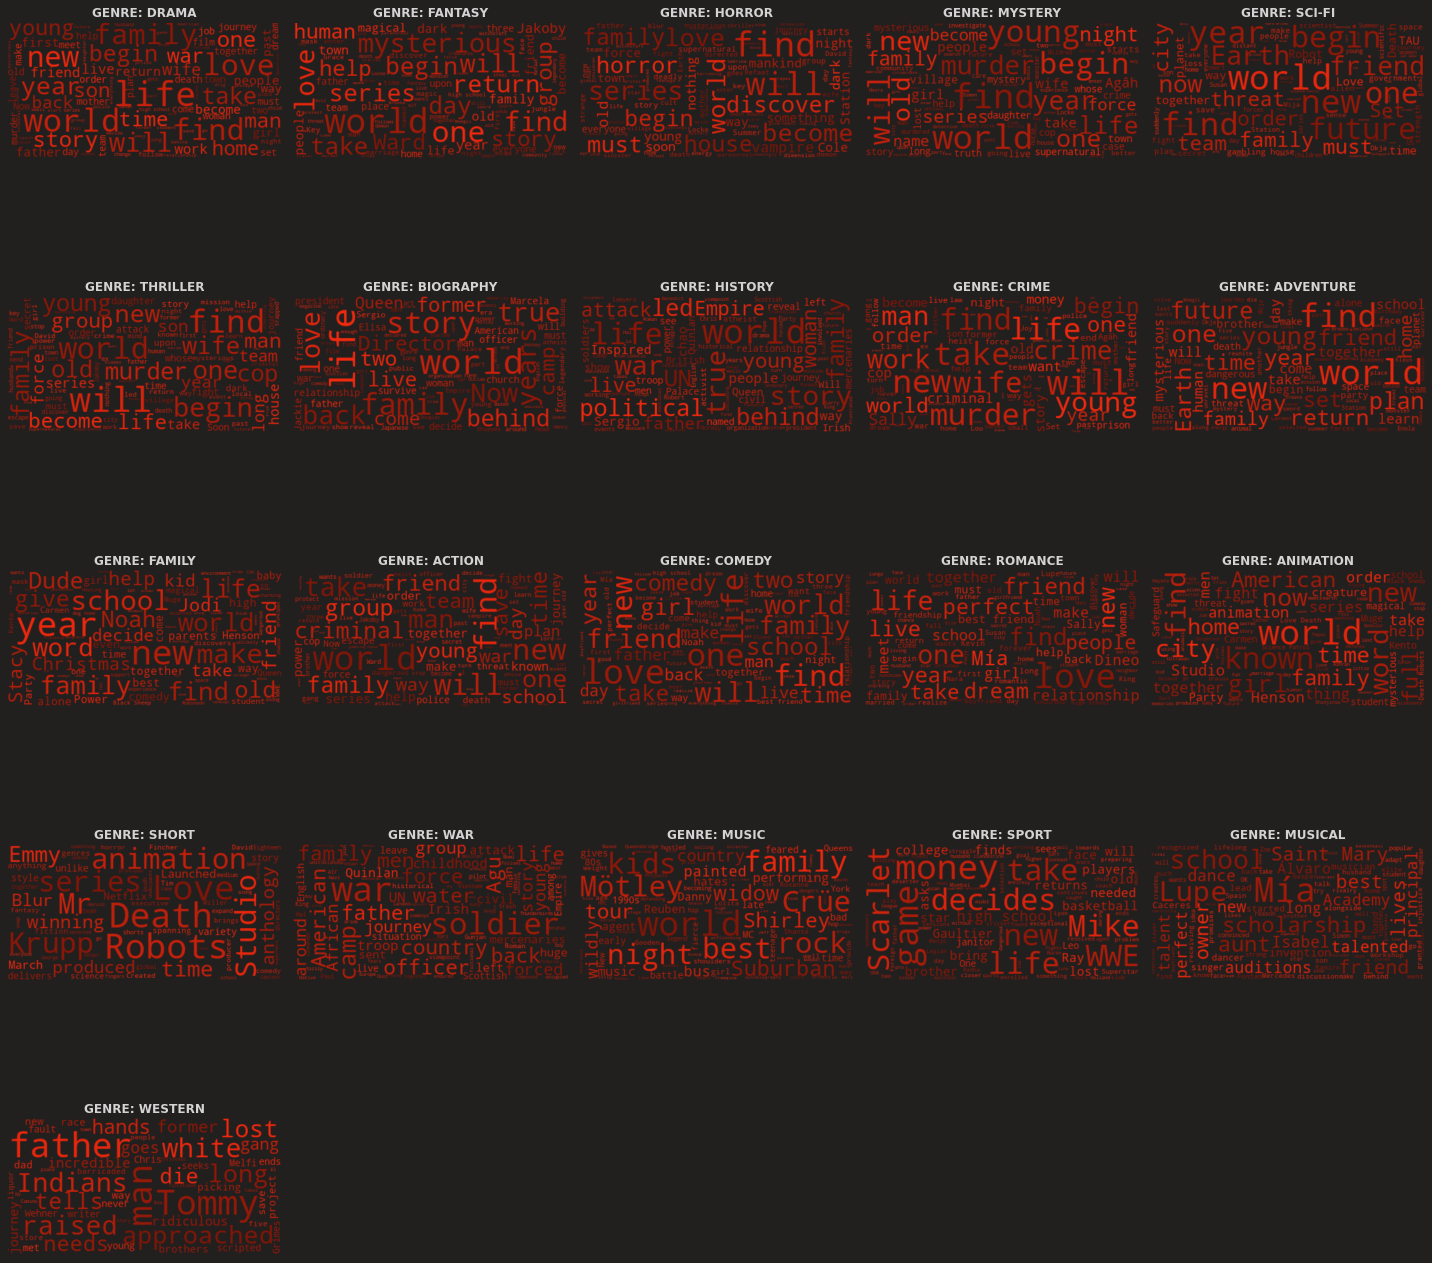

In [ ]:
# creating list with the genres
GenreDescription_List = list(GenreDescription.keys())

# draw wordcloud
d = 0
fig, ax = plt.subplots(figsize=(20,20), facecolor = "#221f1f", nrows=5, ncols=5)
for i in range(len(GenreDescription.keys())):
    plt.subplot(5, 5, i+1)
    wordcloud_marvel = WordCloud(max_font_size=50, max_words=100, background_color="#221F1F", color_func=random_color_func).generate(documentComList[d])
    #ax = fig.add_subplot(5, 5, d+1)
    plt.imshow(wordcloud_marvel, interpolation='bilinear')
    plt.title(str.upper('Genre: ' + GenreDescription_List[i]), fontweight='bold', color = "lightgrey")
    plt.axis("off")
    plt.grid(False)
    d = d+1
    plt.subplots_adjust(wspace = 0.3, hspace = 0.05)

fig.delaxes(ax[4][1])
fig.delaxes(ax[4][2])
fig.delaxes(ax[4][3])
fig.delaxes(ax[4][4])

plt.tight_layout()
plt.savefig(path + 'Wordcloud_ByGenres.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 300)
plt.show()

# https://www.xspdf.com/help/52264488.html look at this maybe

*Looking at the word clouds of the different genres above, we can clearly get a sense of which word cloud belongs to which genre, without looking at the titles of each word cloud. For example in the "War" word cloud, words such as, "war, camp, american, soldier, officer, etc." are present which gives us a sense of a war theme being present. In the "Sport" word cloud, words such as, "WWE, game, money, players, basketball, etc." are present, which again gives a great picture of the genre.*

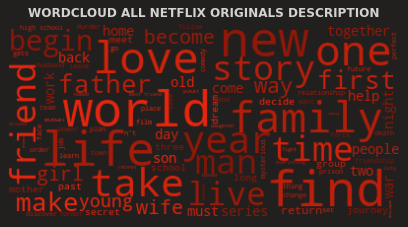

In [ ]:
# drawing the wordclouds of all Netflix Originals Description
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="#221F1F", color_func=random_color_func).generate(tokensMovie_str + tokensTV_str)


fig = plt.figure(facecolor = "#221f1f")
plt.imshow(wordcloud_ALL, interpolation='bilinear')
plt.title(str.upper("Wordcloud all Netflix Originals Description"), color = "lightgrey", fontweight = 'bold')
plt.axis("off")
plt.tight_layout()
plt.savefig(path + 'WordCloud_ALL.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 300)
plt.show()

*We also created a word cloud of all the descriptions of the content in order to get a general sense of what the content is about. Words such as, "Love, world, family, live, friend, story, etc." gives us the sense that a lot of the content is about these different themes. This makes sense when you compare it to the amount of content that is under the genres "Drama" and "Comedy".*

### **Sentimental Analysis**

*In this section, we are going to look into the sentiment analysis mainly in the descriptions of each content which we got from IMDb. And also we analyzed reviews from IMDb for top 6 Netflix originals. To do the sentimental analysis we are again using NLTK's Tokenizer and excluding Stopwords.* 

#### **Initialize**
*Firstly we import the dataset again, so we don't have any deleted rows. Thereafter the `labMT.txt` is imported from Github to get the ranks of the different words. Then we defined some functions to estimate the sentiment of a list of tokens `sentiment(tokens)`, Exclude punctuation `Punctuation(tokens)`, Exclude stop words using `stopwords`, lowercase all other words `StopWords(tokens)`, exclude numbers using re.sub `NumbersAndLinks(txt)` and then combine everything together by the function `formatText(txt)`.*

In [ ]:
# Reading the pickle file
combined = pd.read_pickle(path + "combined.pkl")

# remove movies without casts 
combined.dropna(subset=['Description'], inplace=True)
combined.reset_index(drop=True, inplace=True)

In [ ]:
# read wordlist
df = pd.read_csv('https://raw.githubusercontent.com/markberger/state-happiness/master/labMT.txt',index_col=0, delimiter = '\\t',engine='python')
wordlist = df.index.values.tolist()

In [ ]:
#Function to estimate the sentiment of a list of tokens
def sentiment(tokens):
    sentiment_score, count = 0, 0
    
    #Considering tokens are standardized (in this case, lowercase)
    for word in tokens:
        if word in wordlist:
            count+=1
            sentiment_score += df.loc[word]['happiness_average']
    
    if count!=0:
        return(sentiment_score/count)
    else:
        return("Invalid")

#Functions to format the tweets in the wanted way.
#Exclude punctuation
def Punctuation(tokens):
    return([w for w in tokens if w.isalpha()])

#Exclude stop words, lowercase all other words
def StopWords(tokens):
    stop_words = set(stopwords.words('english'))
    return([w.lower() for w in tokens if not w.lower() in stop_words])

#Exclude numbers
def NumbersAndLinks(txt):
    new = re.sub('[0-9]+', '', txt)
    new = re.sub('https:(\S)*', '', txt)
    return(new)

#Final function
def formatText(txt):
    return(StopWords(Punctuation(word_tokenize(NumbersAndLinks(txt)))))

#### **Sentimental score by content**

In [ ]:
# Saving sentiment score in sentiment
sentiment_dict = {}

j = 0
for i in combined['Title']:
    content = combined['Description'][j]
    txt = content
    txt_formatted = formatText(txt)
    #print((txt_formatted))
    sentiment_dict.update({i : sentiment(txt_formatted).round(3)})
    j = j+1
print('Dictionary done')

# list(sentiment_dict.values())

In [ ]:
scores = list(sentiment_dict.values())
print('The average sentiment score of all content : ', sum(scores)/len(scores))

The average sentiment score of all content :  5.646901960784314


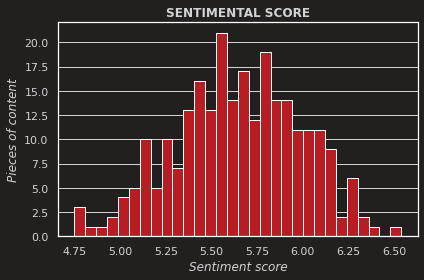

In [ ]:
# creating histogram of the sentimentalscore
values = []
fig, ax = plt.subplots(facecolor = "#221f1f")
for i in sentiment_dict.values():
  values.append(float(i))

type(values[1])

plt.hist(values, bins=30, color = '#b81d24')
plt.xlabel('Sentiment score', style='italic')
plt.ylabel('Pieces of content',  style='italic')
plt.title(str.upper('Sentimental score'), color = "lightgrey", fontweight = 'bold')

ax.tick_params(colors = "lightgrey")
ax.yaxis.label.set_color('lightgrey')
ax.xaxis.label.set_color('lightgrey')
ax.set_facecolor('#221f1f')
plt.grid(color = "lightgrey")
ax.xaxis.grid(False)
plt.tight_layout()
#plt.savefig(path + 'SentimentalScore.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

*First of all, the sentiment score of the whole content is calculated to see the distribution overall. We can observe that the shape of histogram follows normal distribution roughly with mean 5.6469.* 

In [ ]:
# by movie
happiestcontents = sorted(sentiment_dict.items(), key = lambda x: x[1], reverse=True)[:10]
saddestcontents = sorted(sentiment_dict.items(), key = lambda x: x[1], reverse=True)[-10:]

print(color.BOLD + str.upper('The 10 contents with happiest description') + color.END)
for x in range(len(happiestcontents)): 
    print(happiestcontents[x])

print(color.BOLD + str.upper('\nThe 10 contents with saddest description') + color.END)
for x in range(len(saddestcontents)): 
    print(saddestcontents[x])

THE 10 CONTENTS WITH HAPPIEST DESCRIPTION
('Nappily Ever After', 6.539)
('Word Party', 6.363)
('Sometimes', 6.317)
('The Half of It', 6.305)
('Go! Live Your Way', 6.294)
('Tall Girl', 6.269)
('Despite Everything', 6.264)
('Love per Square Foot', 6.245)
('Masaba Masaba', 6.243)
('The Kissing Booth 2', 6.243)

THE 10 CONTENTS WITH SADDEST DESCRIPTION
('War Machine', 5.028)
('Guilty', 5.027)
('Point Blank', 4.998)
('Earthquake Bird', 4.943)
('Elite', 4.94)
('Hache', 4.927)
('Delhi Crime', 4.809)
('Extraction', 4.782)
('Small Crimes', 4.781)
('The Crimes That Bind', 4.749)


*And the top 10 and last 10 of the sentiment score is printed out. The movie with the highest sentiment score is, "Nappily Ever After", and the movie with the lowest sentiment score is, "The Crimes That Bind". In the analysis part of the website, you can get a clearer picture of how this was achieved.*

#### **Sentimental score by genre**

In [ ]:
# Saving sentiment score for each genre in sentiment
sentiment_dict_genre = {}
j = 0
for i in genre.keys():
    content = GenreDescription[i]
    txt = content
    txt_formatted = formatText(str(txt))
    sentiment_dict_genre.update({i : str(sentiment(txt_formatted).round(3))})
    j = j+1
print('Dictionary done')

Dictionary done


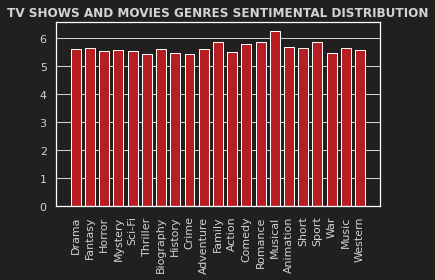

In [ ]:
#X = np.arange(len(sentiment_dict_genre.keys()))
X_sent = sentiment_dict_genre.keys()
fig, ax = plt.subplots(facecolor = "#221f1f")

plt.bar(X_sent, list(map(float, list(sentiment_dict_genre.values()))),
        width=0.7, color = '#b81d24')

ax.tick_params(colors = "lightgrey")
ax.yaxis.label.set_color('lightgrey')
ax.xaxis.label.set_color('lightgrey')
ax.set_facecolor('#221f1f')
plt.grid(color = "lightgrey")
ax.xaxis.grid(False)
plt.xticks(rotation = 90)
plt.title(str.upper("Tv shows and Movies genres sentimental distribution"),
          color = "lightgrey", fontweight = 'bold')
plt.tight_layout()
plt.savefig(path + 'SentimentalHistofGenre.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

*Secondly, the sentiment score is calculated in each genre. While we expected to have characteristic score, the scores are in uniform. We assumed that the description is trying to be neutral not to spoil the whole plot to subscribers. Not only that the desciption should be in one line, the one liner is mostly twisted to grab our attention. Therefore, having neurtal stand makes sense in every genre.*

### **Review Analysis**
*In this section, we are doing a review analysis of the Top 6 Netflix Originals. To do so, we imported the dataset again, as we needed all the Netflix Originals, sorted the table by the column `rating` and then extracted the top 6 Netflix Originals. Thereafter we extracted the IMDb ID of each of the top Originals using the function `ia.search_movie`. Then we combined the Netflix Orignals ID with the url pattern to access the review site of a particular movie or TV show. Looking into the source code of an IMDb review page, we could observe that the reviews are stored in the `review-container` class and to extract the reviews we us the Python library, Beautiful Soup, for pulling data out of a HTML page. After the reviews have been extracted from IMDb, we stored the reviews in a dictionary with their corresponding Netflix Originals.*


In [ ]:
# Reading the pickle file
combined = pd.read_pickle(path + "combined.pkl")

In [ ]:
combined.dropna(subset=['Rating'], inplace=True)
combined.reset_index(drop=True, inplace=True)
ratingDict = {}

for i in range(len(combined['Title'])):
    ratingDict.update({combined['Title'][i] : combined['Rating'][i]})

# sort by ratings 
sort_ratingDict = sorted(ratingDict.items(), key=lambda x: x[1], reverse=True)

# Top 6
topFive = sort_ratingDict[2:8]

# Extracting only names
n = 0 # N. . .
NameOnly = [x[n] for x in topFive]

In [ ]:
# Getting the top 10 reviews from IMDb using BeautifulSoup
reviews = {}

for j in NameOnly:
  reviews.update({ j : []})

  name = j
  search = ia.search_movie(j)
  url2 = search[0].movieID
  type(search[0].movieID)

  url1 = 'http://www.imdb.com/title/tt'
  url3 = '/reviews?ref_=tt_urv'
  url123 = url1 + url2 + url3
  
  res = requests.get(url123)
  soup = BeautifulSoup(res.text,"lxml")

  main_content = urljoin(url123,soup.select(".load-more-data")[0]['data-ajaxurl'])  ##extracting the link leading to the page containing everything available here
  response = requests.get(main_content)
  broth = BeautifulSoup(response.text,"lxml")

  for item in broth.select(".review-container"):
    reviews[j].append((item.select(".text")[0].text))
  
  print("Done running:", j)

In [ ]:
# Saving sentiment score for each genre in sentiment
sentiment_dict_reviews = {}
j = 0
for i in reviews.keys():
    content = reviews[i]
    content = ' '.join(map(str, content))
    txt_formatted = formatText(content)
    sentiment_dict_reviews.update({i : str(sentiment(txt_formatted).round(3))})
    j = j+1
print('Dictionary done')

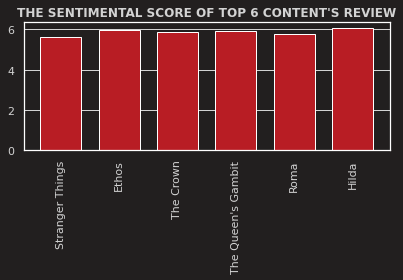

In [ ]:
#X = np.arange(len(sentiment_dict_genre.keys()))
Xreviews = sentiment_dict_reviews.keys()
fig, ax = plt.subplots(facecolor = "#221f1f")

plt.bar(Xreviews, list(map(float, list(sentiment_dict_reviews.values()))),
        width=0.7, color = '#b81d24')

ax.tick_params(colors = "lightgrey")
ax.yaxis.label.set_color('lightgrey')
ax.xaxis.label.set_color('lightgrey')
ax.set_facecolor('#221f1f')
plt.grid(color = "lightgrey")
ax.xaxis.grid(False)
plt.xticks(rotation = 90)
plt.title(str.upper("The sentimental score of Top 6 content's review"),
          color = "lightgrey", fontweight = 'bold')
plt.tight_layout()
#plt.savefig(path + 'SentimentalHistofReviews.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 200)
plt.show()

*Lastly, the sentiment score is calculated in the top six rated piece of content. The scores are from minimum 5.788 to maximum 6.047, which are slightly higher than the average sentiment score 5.6469.* 

*It is interesting to compare the sentiment score to the review score on IMDb. For example, the review score for "Stranger Things" is 8.8 on IMDb, while the review score for "Hilda" is 8.5. However, the sentiment score is greater for "Hilda" than it is for "Stranger things". This can partly be due to the runtime of the two shows ("Stranger things" have three seasons and "Hilda" has one season). There is a tendency with shows becoming duller over time and so the latest reviews of "Stranger things" can be bad while the previous reviews are great. It can also be due to the content of the two shows. "Stranger things" is about monsters and aliens, while "Hilda" is a cartoon about a little girl. The words used in the reviews can potentially reflect the content and so, as mentioned previously, when doing a sentiment analysis, because it only analyzes the words and not the context, the sentiment score could end up becoming lower than what should be the case.*

In [ ]:
# drawing the wordclouds
for i in reviews:
  IMDbreviews = [i for i in word_tokenize(' '.join(map(str, reviews[i])).lower()) if i not in stop]
  IMDbreviews = ' '.join(IMDbreviews)
  wordcloud_Reviews = WordCloud(max_font_size=50, max_words=100, background_color="#221F1F", color_func=random_color_func).generate(IMDbreviews)

#  wordcloud_Reviews = WordCloud(max_font_size=50, max_words=100, background_color="#221F1F", color_func=random_color_func).generate(' '.join(map(str, reviews[i])))

  fig = plt.figure(figsize=(20,7), facecolor = "#221f1f")
  # Movies wordcloud:
  plt.subplot(1, 2, 1)
  plt.imshow(wordcloud_Reviews, interpolation='bilinear')
  plt.title(str.upper('Content {}'.format(i)), color = "lightgrey", fontweight = 'bold')
  plt.axis("off")
  print("\n")

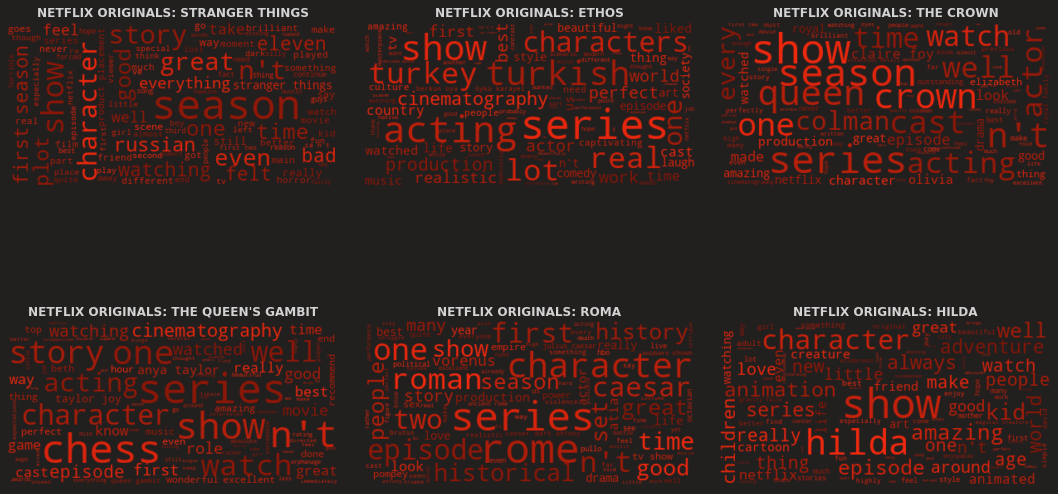

In [ ]:
# creating list with the genres
# draw wordcloud
d = 0
fig, ax = plt.subplots(figsize=(15,10), facecolor = "#221f1f", nrows=5, ncols=5)
for i in reviews:
    plt.subplot(2, 3, d+1)
    IMDbreviews = [i for i in word_tokenize(' '.join(map(str, reviews[i])).lower()) if i not in stop]
    IMDbreviews = ' '.join(IMDbreviews)
    wordcloud_Reviews = WordCloud(max_font_size=50, max_words=100, background_color="#221F1F", color_func=random_color_func).generate(IMDbreviews)
    #wordcloud_marvel = WordCloud(max_font_size=50, max_words=100, background_color="#221F1F", color_func=random_color_func).generate(documentComList[d])
    #ax = fig.add_subplot(5, 5, d+1)
    plt.imshow(wordcloud_Reviews, interpolation='bilinear')
    plt.title(str.upper('Netflix Originals: {}'.format(i)), fontweight='bold', color = "lightgrey")
    plt.axis("off")
    plt.grid(False)
    d = d+1
    plt.subplots_adjust(wspace = 0.1, hspace = 0.1)

plt.tight_layout()
plt.savefig(path + 'Wordcloud_ByTopMoviesReview.jpg', facecolor = fig.get_facecolor(),transparent=False, dpi = 300)
plt.show()

# https://www.xspdf.com/help/52264488.html look at this maybe

# **4 | Discussion**

## **What went well?**

*While our dataset is fairly small, we managed to analyze it in multiple ways, getting as much out of it as possible. It served well for what we wanted to figure out and we ended up with some nice findings, in our opinion.*

*We are very happy with how everything is connected in some way, from the network to the word clouds, to the sentiment analysis, etc. Our project has a nice, red thread throughout. Furthermore, we are very happy with our plots, as we got them visualized just the way we wanted to, both with the data we wanted to show and the how we wanted to show it (types of plot, colors, etc.).*

*We were able to get the findings we wanted from analysing the descriptions, which we were very pleased with.* 


## **What is still missing? What could be improved?, Why?**

*We wanted to make a sentiment analysis of the reviews from the top five highest rated movies on IMDb. We got the code to work which was amazing. However, we had to take the third to eigth highest rated content due to some content in our dataframe having the same name as content that is not Netflix original content taken from IMDb. It could not distinquish this content and so, we had to do a workaround. If we were to work further with the project, we would find a way to do this workaround, for example by using a different method for collecting the data from IMDb than the module that we currently use.* 

*We could improve on the quality of our dataset. We had a lot of problems with the way we gathered our data and merged the Wikipedia and IMDb, which meant that some movies would be overwritten by other movies with the same name (movies that weren't netflix originals).*

*Furthermore, the first original content released by Netflix wasn't on Wikipedia, which meant that we didn't include it in the dataset. We could improve on this by gathering data from elsewhere in order to get a more complete dataset.* 

# **5 | Contribution**

*While we all worked on every aspect of the project together and therefore all had a great influence on everything, we tried to have different group members be "managers" of different aspects.*

*We want to be clear, that although one of the group members have a specific part in their list, we all worked together in every part. The job of the "manager" was to finalize in the notebook and analysis, as well as clarify.*

<br>

**Notebook:** <br>
<u>Chapter 1</u>: *Branavan* <br>
<u>Chapter 2</u>: *Branavan, Yeonsoo, Sebastian* <br>
<u>Chapter 3</u>: *Branavan, Yeonsoo, Sebastian* <br>
<u>Chapter 4</u>: *Sebastian, Yeonsoo*

<br>

**Analysis:** <br>
<u>Introduction</u>: *Sebastian* <br>
<u>Overview of data</u>: *Yeonsoo* <br>
<u>The Network of Netflix Original Content</u>: *Branavan, Yeonsoo, Sebastian* <br>
<u>Text analysis</u>: *Branavan, Sebastian* <br>
<u>Sentiment Analysis</u>: *Yeonsoo*

*For some of the parts, multiple group members have been "managers" due to there being a lot of content to finalize and clarify.*

# **6 | References**

[1] https://www.kaggle.com/shivamb/netflix-shows-and-movies-exploratory-analysis/notebook

[2] https://www.journaldev.com/19410/networkx-python-graph-library#1-python-networkx

[3] https://github.com/bhargavchippada/forceatlas2

[4] https://python-graph-gallery.com/wordcloud/

[5] https://www.tutorialspoint.com/python_text_processing/python_remove_stopwords.htm
